In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! cp /content/drive/MyDrive/Dataset/archive.zip /content

In [3]:
! apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [4]:
!unzip archive.zip -d data

Archive:  archive.zip
  inflating: data/Testing/glioma_tumor/image(1).jpg  
  inflating: data/Testing/glioma_tumor/image(10).jpg  
  inflating: data/Testing/glioma_tumor/image(100).jpg  
  inflating: data/Testing/glioma_tumor/image(11).jpg  
  inflating: data/Testing/glioma_tumor/image(12).jpg  
  inflating: data/Testing/glioma_tumor/image(13).jpg  
  inflating: data/Testing/glioma_tumor/image(14).jpg  
  inflating: data/Testing/glioma_tumor/image(15).jpg  
  inflating: data/Testing/glioma_tumor/image(16).jpg  
  inflating: data/Testing/glioma_tumor/image(17).jpg  
  inflating: data/Testing/glioma_tumor/image(18).jpg  
  inflating: data/Testing/glioma_tumor/image(19).jpg  
  inflating: data/Testing/glioma_tumor/image(2).jpg  
  inflating: data/Testing/glioma_tumor/image(20).jpg  
  inflating: data/Testing/glioma_tumor/image(21).jpg  
  inflating: data/Testing/glioma_tumor/image(22).jpg  
  inflating: data/Testing/glioma_tumor/image(23).jpg  
  inflating: data/Testing/glioma_tumor/image

In [5]:
!pip install torchinfo

In [6]:
! cp /content/drive/MyDrive/Code/classes.py /content
! cp /content/drive/MyDrive/Code/helper_functions.py /content
! cp /content/drive/MyDrive/Code/plot_functions.py /content

In [7]:
from helper_functions import *
from classes import *
from torch.utils.data import DataLoader
from torchvision import transforms
from timeit import default_timer as timer
from plot_functions import *
import sklearn.model_selection

In [18]:
# Define the hyperparameters
DATA_DIR = 'data' # Path to the data directory
BATCH_SIZE = 32 # Batch size for the dataloaders
IN_CHANNELS = 3 # Number of input channels
HIDDEN_UNITS = 32  # Number of hidden units in the fully connected layer
NUM_CLASSES = 4 # Number of classes in the dataset
SIZE = 224 # Size of the images
LEARNING_RATE = 0.001 # Learning rate for the optimizer
EPOCHS = 250 # Number of epochs to train the model
GAMMA = 0.1 # Multiplicative factor of learning rate decay
STEP_SIZE = 20 # Step size for the learning rate scheduler
WEIGHT_DECAY = None # Weight decay for the optimizer
SEED = 1678737 # Seed for reproducibility
RANDOM_ROTATION = 35  # Random rotation for the images
MOMENTUM = 0.9  # Momentum for the optimizer
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the dictionary that hold the hyperparameters
hyperparameters = {
        'BATCH_SIZE': BATCH_SIZE,
        'IN_CHANNELS': IN_CHANNELS,
        'HIDDEN_UNITS': HIDDEN_UNITS,
        'NUM_CLASSES': NUM_CLASSES,
        'SIZE': SIZE,
        'LEARNING_RATE': LEARNING_RATE,
        'EPOCHS': EPOCHS,
        'GAMMA': GAMMA,
        'STEP_SIZE': STEP_SIZE,
        'WEIGHT_DECAY': WEIGHT_DECAY,
        'SEED': SEED,
        'RANDOM_ROTATION': RANDOM_ROTATION,
        'DEVICE': DEVICE
    }

In [9]:
from torchvision import transforms

def get_transforms(in_channels, size, random_rotation):
    if in_channels == 3:
        return transforms.Compose([
            transforms.Resize((size, size)),
            transforms.RandomRotation(random_rotation),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.2, 0.2, 0.2], std=[0.2, 0.2, 0.2])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((size, size)),
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            transforms.RandomRotation(random_rotation, ),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

# Example usage
train_transform = get_transforms(in_channels=IN_CHANNELS, size=SIZE, random_rotation=RANDOM_ROTATION)
test_transform = get_transforms(in_channels=IN_CHANNELS, size=SIZE, random_rotation=0)

In [10]:
# Define the classes
classes = {
    'no_tumor': 0,
    'meningioma_tumor': 1,
    'pituitary_tumor': 2,
    'glioma_tumor': 3
}

In [11]:
walk_through_dir(DATA_DIR)

# Pre-Process the dataset
combined_dir = combine_and_rename_images(DATA_DIR,classes)

walk_through_dir(combined_dir)
# Split the dataset into train, validation, and test sets

There are 2 directories and 0 images in 'data'.
There are 4 directories and 0 images in 'data/Training'.
There are 0 directories and 822 images in 'data/Training/meningioma_tumor'.
There are 0 directories and 826 images in 'data/Training/glioma_tumor'.
There are 0 directories and 395 images in 'data/Training/no_tumor'.
There are 0 directories and 827 images in 'data/Training/pituitary_tumor'.
There are 4 directories and 0 images in 'data/Testing'.
There are 0 directories and 115 images in 'data/Testing/meningioma_tumor'.
There are 0 directories and 100 images in 'data/Testing/glioma_tumor'.
There are 0 directories and 105 images in 'data/Testing/no_tumor'.
There are 0 directories and 74 images in 'data/Testing/pituitary_tumor'.


Combining and renaming images: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

Images combined and renamed successfully.
There are 0 directories and 3264 images in 'Combined'.


In [12]:
# Load data into a Pandas DataFrame
df = load_data_to_dataframe('Combined')
#shutil.rmtree('Combined')

Loading images: 100%|██████████| 3264/3264 [00:00<00:00, 319909.53it/s]


In [13]:
# Step 1: Split the dataset into 85% (train + val) and 15% (test)
train_val_df, test_df = sklearn.model_selection.train_test_split(
    df, test_size=0.15, shuffle=True, stratify=df['label']
)

# Step 2: Split the train_val_df into 70% (train) and 15% (validation)
train_df, val_df = sklearn.model_selection.train_test_split(
    train_val_df, test_size=0.1765, shuffle=True, stratify=train_val_df['label']
)  # 0.1765 ≈ 15/85 to get validation as 15% of total

# Print the sizes to verify
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 2284
Validation set size: 490
Test set size: 490


In [14]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Create the DataLoaders for train, validation, and test sets
train_loader = DataLoader(CustomDataset(train_df, transform=train_transform), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(CustomDataset(val_df, transform=test_transform), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(CustomDataset(test_df, transform=test_transform), batch_size=BATCH_SIZE, shuffle=False)


In [19]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze all layers except the last convolutional layer and the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last convolutional layer
for param in model.layer4.parameters():
    param.requires_grad = True

# Modify the classifier to have 4 output classes
model.fc = nn.Linear(model.fc.in_features, 4)

# Move the model to the specified device
model = model.to(DEVICE)

# Define the optimizer and the loss function
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=MOMENTUM)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
start = timer()

results = train(model,
                train_loader,
                val_loader,
                loss_fn,
                optimizer,
                EPOCHS,
                DEVICE,
                scheduler=scheduler,
                early_stopping=True,
                times_not_optimizing=2,
                acc_target = 0.95)

end = timer()

[Epoch 9/250] Testing: 100%|██████████| 16/16 [00:03<00:00,  4.02it/s, Loss: 0.2531 | Accuracy: 90.3906%]


Reached Wanted Accuracy
Saving Best weights and reseting the counter to 0 from 0


[Epoch 10/250] Testing: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s, Loss: 0.2115 | Accuracy: 92.3438%]


Reached Wanted Accuracy
Saving Best weights and reseting the counter to 0 from 0


[Epoch 11/250] Testing: 100%|██████████| 16/16 [00:03<00:00,  4.70it/s, Loss: 0.2677 | Accuracy: 90.6250%]


Reached Wanted Accuracy


[Epoch 12/250] Testing: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s, Loss: 0.1896 | Accuracy: 93.3203%]


Reached Wanted Accuracy
Saving Best weights and reseting the counter to 0 from 1


[Epoch 13/250] Testing: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, Loss: 0.1621 | Accuracy: 95.1172%]


Reached Wanted Accuracy
Saving Best weights and reseting the counter to 0 from 0


[Epoch 14/250] Testing: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s, Loss: 0.1638 | Accuracy: 93.9453%]


Reached Wanted Accuracy


[Epoch 15/250] Testing: 100%|██████████| 16/16 [00:03<00:00,  4.04it/s, Loss: 0.1795 | Accuracy: 94.1406%]

Reached Wanted Accuracy
Early stopping at epoch 15


In [21]:
from datetime import timedelta

# Assuming 'end' and 'start' are defined timestamps
elapsed_time = end - start
formatted_time = str(timedelta(seconds=elapsed_time))

print(f'Training time: {formatted_time}')

Training time: 0:06:02.548097


In [22]:
eval_res = evaluate(model,
                          test_loader,
                          loss_fn,
                          DEVICE)

[Epoch 1/1] Testing: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s, Loss: 0.1676 | Accuracy: 94.5312%]

Evaluation results
Test Loss: 0.1676 | Test Acc: 94.53%
Class 0 - AUC: 1.00, Sensitivity: 0.97
Class 1 - AUC: 0.99, Sensitivity: 0.91
Class 2 - AUC: 1.00, Sensitivity: 0.93
Class 3 - AUC: 0.99, Sensitivity: 0.96


Normalized confusion matrix


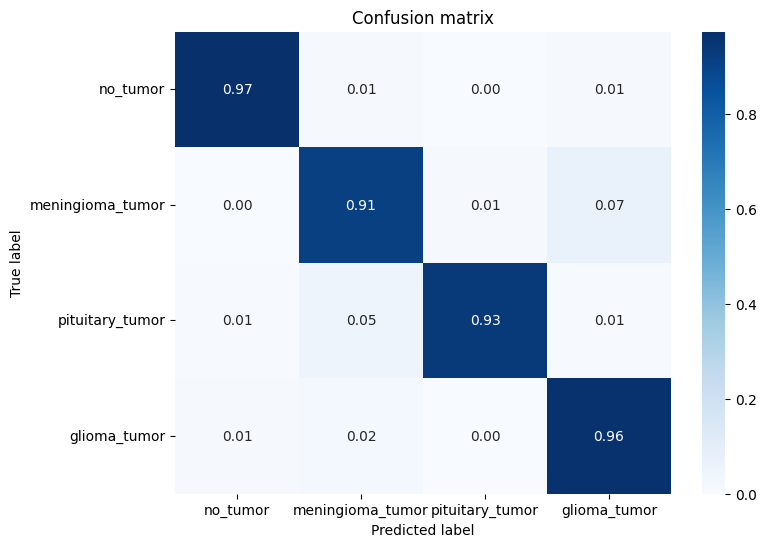

In [24]:
import numpy as np

# Assuming eval_res is the evaluation results returned by the evaluate function
y_true = eval_res['all_targets']
y_pred_continuous = eval_res['all_preds']

# Convert continuous predictions to discrete class labels
y_pred = np.argmax(y_pred_continuous, axis=1)

# Now you can compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with sensitivity values
plot_confusion_matrix_with_sensitivity(cm, classes, normalize=True)

<Figure size 1500x700 with 0 Axes>

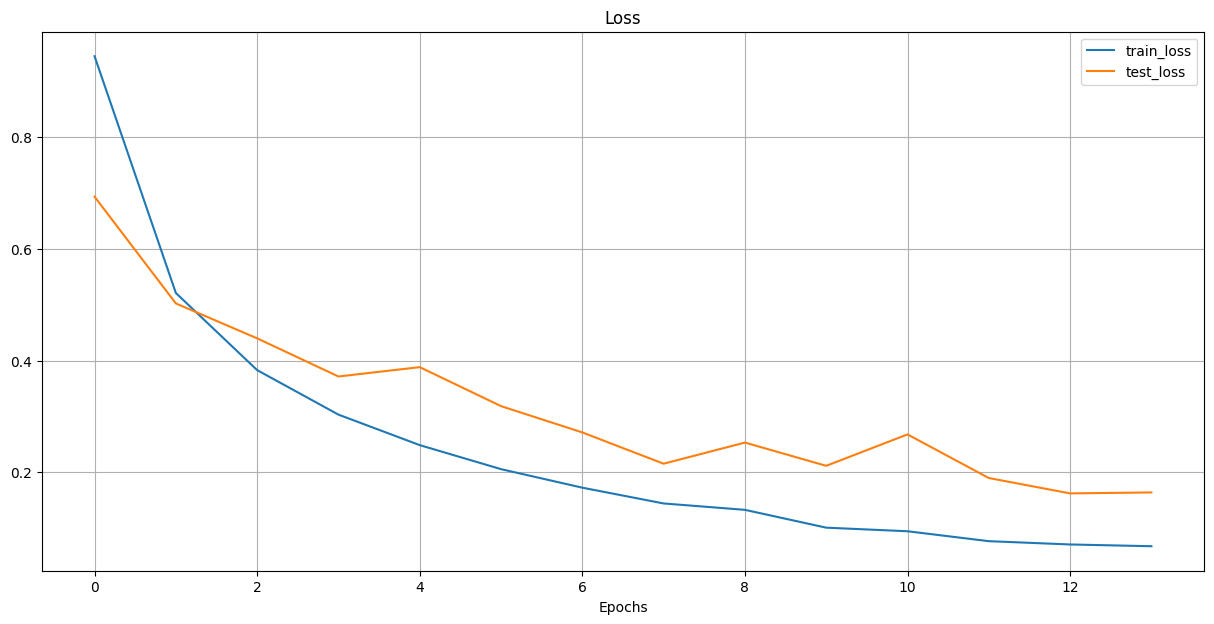

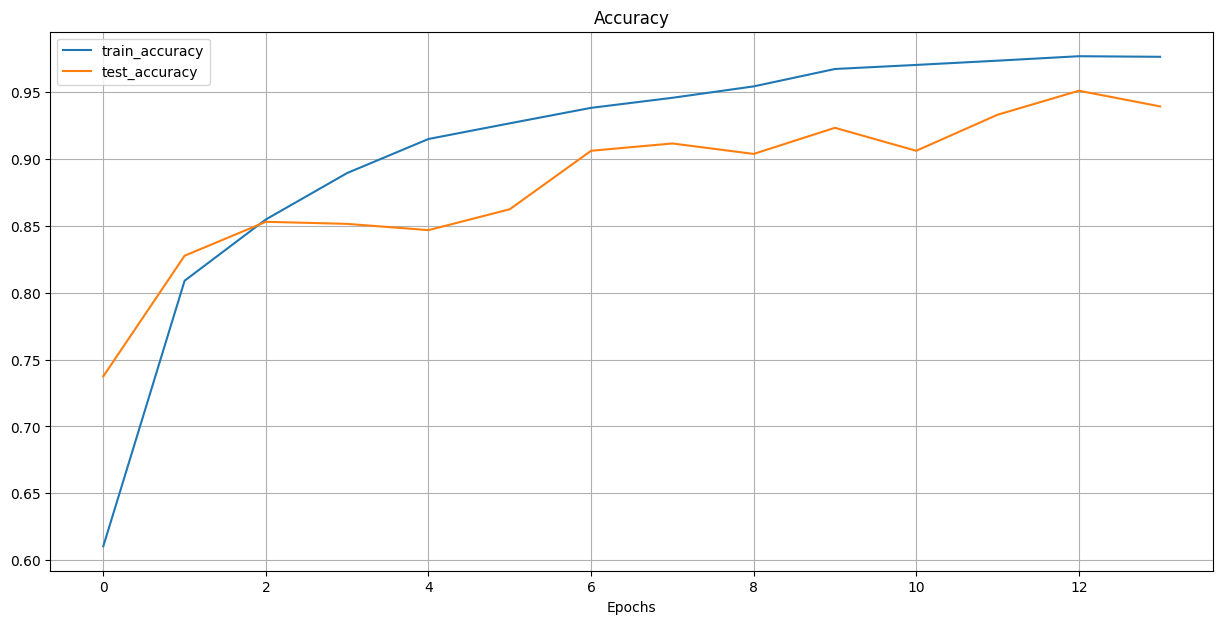

In [25]:
# Plot loss and accuracy
plot_loss_curves(results)

In [26]:
from torchvision import models
from torchsummary import summary

summary(model, (IN_CHANNELS, SIZE, SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

all_preds shape: (490, 4)
all_labels shape: (490,)
Class no_tumor - AUC: 1.00, Precision: 0.96, Recall (Sensitivity): 0.97, F1 Score: 0.97
Class meningioma_tumor - AUC: 0.99, Precision: 0.92, Recall (Sensitivity): 0.91, F1 Score: 0.92
Class pituitary_tumor - AUC: 1.00, Precision: 0.98, Recall (Sensitivity): 0.93, F1 Score: 0.96
Class glioma_tumor - AUC: 0.99, Precision: 0.92, Recall (Sensitivity): 0.96, F1 Score: 0.94


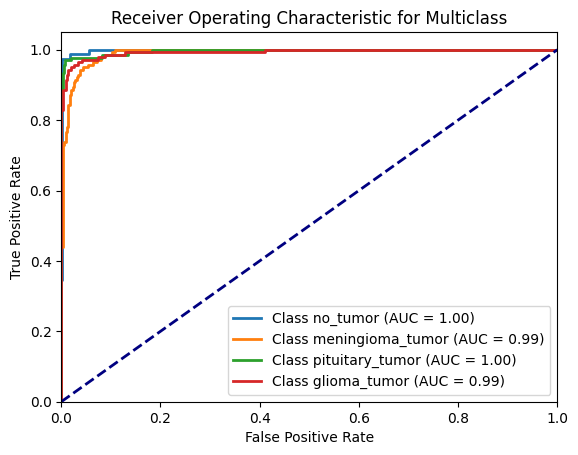

In [27]:
plot_metrics(eval_res, classes)